In [77]:
import os
import nltk
import re
import json
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import requests
import time
import glob
import numpy as np
import shutil
import seaborn as sns
from collections import Counter
import pandas as pd
import math
from wordcloud import WordCloud
import json

# Functions used in the code

In [46]:
def get_page_wikitext(page_title):
    """Get raw wiki markup for a page"""
    url = "https://gameofthrones.fandom.com/api.php"
    
    params = {
        "action": "query",
        "prop": "revisions",
        "titles": page_title,
        "rvprop": "content",
        "format": "json",
        "rvslots": "main"
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()
        
        page = next(iter(data["query"]["pages"].values()))
        
        # Check if page exists and has content
        if "revisions" in page:
            wikitext = page["revisions"][0]["slots"]["main"]["*"]
            return wikitext
        else:
            return None
    except Exception as e:
        print(f"    Error: {e}")
        return None

def save_wikitext_to_file(page_title, wikitext, output_dir):
    """Save wikitext to a file"""
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Clean the filename (remove invalid characters)
    filename = page_title.replace("/", "_").replace("\\", "_").replace(":", "_")
    filename = filename.replace("?", "_").replace("*", "_").replace("|", "_")
    filename = filename.replace("<", "_").replace(">", "_").replace('"', "_")
    filepath = os.path.join(output_dir, f"{filename}.txt")
    
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(wikitext)
    
    return filepath

def load_text_files(file: str, path: str = 'GoT_files', newLine: bool = False) -> str:
    with open(os.path.join(path, file), 'r', encoding='utf-8', errors='ignore') as f:
        if newLine:
            text = f.read().splitlines()
        else:
            text = f.read()

    return text

def load_graphs(graph: str, path: str = 'graphs'):
    with open(os.path.join(path,graph), 'rb') as f:
        loaded_graph = pickle.load(f)
    
    return loaded_graph

def load_all_files(path: str = 'GoT_files') -> dict:
    pages = os.listdir(path)

    page_titles = [f for f in pages if not f.startswith('fetched_pages_')]
    page_titles = [f for f in page_titles if not f.startswith('redirects_')]
    page_titles = [f for f in page_titles if not f.startswith('failed_pages_')]

    page_texts = {}

    for file in pages:
        # Skip files in Doubles subfolder and skip directories
        if file == 'Doubles' or os.path.isdir(os.path.join(path, file)):
            continue
            
        page_name =  file.replace(".txt", "")
        text = load_text_files(file,path)
        page_texts[page_name] = text
    
    return page_texts

def clean_links(matches, category_map):
    categories = []
    links = []
    for m in matches:
        m = m.replace('[','').replace(']','')
        if 'Category:' in m:
            categories.append(m.replace('Category:','')),
            
        elif 'category:' in m:
            categories.append(m.replace('category:',''))
        else:
            if '|' in m:
                links.append(m.split('|')[0])
            else:
                links.append(m)
    categories = clean_categories(categories,category_map)

    return links, categories
    



def tokenize_text(text: str) -> list:
    tokens = nltk.word_tokenize(text)

    # Filter out punctuation and convert to lowercase in one pass
    tokens = [token.lower() for token in tokens]
    return tokens


def check_categories(text: str, unique_categories: list = []) -> list:
    """Extract wiki [[Category:...]] values from raw text and append to unique_categories.

    Uses a regex that handles single or double brackets and is case-insitive.
    Returns the updated unique_categories list.
    """

    # Match [[Category:...]] (captures the inner content up to the first closing ]])
    pattern = re.compile(r"\[\[\s*Category\s*:\s*(.+?)\s*\]\]", flags=re.IGNORECASE)
    matches = pattern.findall(text)

    for m in matches:
        cat = m.strip()
        # normalize whitespace inside category
        cat = ' '.join(cat.split())
        if cat not in unique_categories:
            unique_categories.append(cat)

    return unique_categories

def clean_categories(raw_categories: list, category_map: dict) -> list:
    """Map raw categories to normalized forms and remove duplicates while preserving order.
    
    Args:
        raw_categories: List of raw category strings
        category_map: Dictionary mapping raw -> normalized category strings
        
    Returns:
        List of unique normalized category strings in order of first appearance
    """
    normalized = []
    seen = set()
    
    for cat in raw_categories:
        # Map to normalized form (use raw if not in mapping)
        norm = category_map.get(cat, cat)
        
        # Only add if we haven't seen this normalized category yet
        if norm not in seen:
            normalized.append(norm)
            seen.add(norm)
    
    return normalized

def load_category_mapping(file: str = 'category_mapping.json', path: str = 'data_handling'):
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        category_map = json.load(f)
    
    return category_map
    

def get_catgories(text: str, raw_categories: list = [], category_map: list = []) -> list:
    if category_map == []:
        category_map = load_category_mapping()
    if raw_categories == []:
        raw_categories = check_categories(text)
    
    cleaned_categories = clean_categories(raw_categories, category_map)

    return cleaned_categories
    
def get_links(text: str, path: str = 'GoT_files', no_files: bool = True, no_translations: bool = True) -> list:

    f = open(os.path.join(path, text), 'r', encoding='utf-8')

    if no_files and no_translations:
        links = re.findall(r"\[{2}(?!\w{2,5}(?:-\w{2})?:)(?!File:)(?!Image:).+?\]{2}", f.read())
    elif no_files:
        links = re.findall(r"\[{2}(?!File:)(?!Image:).+?\]{2}", f.read())
    elif no_translations:
        links = re.findall(r"\[{2}(?!\w{2,5}(?:-\w{2})?:).+?\]{2}", f.read())
    
    return links

def get_links_by_section(file: str, path: str = 'GoT_files', no_files: bool = True, no_translations: bool = True) -> dict:
    """Extract links from a wiki page, organized by section.
    
    Args:
        file: Filename to read (e.g., 'Page Name.txt')
        path: Directory containing the file
        no_files: If True, exclude File: and Image: links
        no_translations: If True, exclude translation links (e.g., [[de:...]])
    
    Returns:
        Dictionary with structure:
        {
            'sections': {
                'Section Name': {
                    'subsections': {
                        'Subsection Name': ['link1', 'link2', ...],
                        ...
                    },
                    'links': ['link1', 'link2', ...]  # Links directly under this section
                },
                ...
            },
            'header': ['link1', 'link2', ...],  # Links before first section
            'categories': ['category1', 'category2', ...]  # Links after <!--Categories-->
        }
    """
    
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Build regex pattern for links
    if no_files and no_translations:
        link_pattern = r"\[\[(?!\w{2,5}(?:-\w{2})?:)(?!File:)(?!Image:)(.+?)\]\]"
    elif no_files:
        link_pattern = r"\[\[(?!File:)(?!Image:)(.+?)\]\]"
    elif no_translations:
        link_pattern = r"\[\[(?!\w{2,5}(?:-\w{2})?:)(.+?)\]\]"
    else:
        link_pattern = r"\[\[(.+?)\]\]"
    
    result = {
        'sections': {},
        'header': [],
        'categories': []
    }
    
    # Split text into parts
    lines = text.split('\n')
    
    current_section = None
    current_subsection = None
    in_categories = False
    
    for i, line in enumerate(lines):
        # Check if we've reached categories
        if '<!--Categories-->' in line:
            in_categories = True
            continue
        
        # Check for section headers
        section_match = re.match(r'^==(.*?)==\s*$', line)
        subsection_match = re.match(r'^===(.*?)===\s*$', line)
        
        if section_match and not subsection_match:
            # Main section (== Section ==)
            current_section = section_match.group(1).strip()
            current_subsection = None
            if current_section not in result['sections']:
                result['sections'][current_section] = {
                    'subsections': {},
                    'links': []
                }
        elif subsection_match:
            # Subsection (=== Subsection ===)
            current_subsection = subsection_match.group(1).strip()
            if current_section:
                if current_subsection not in result['sections'][current_section]['subsections']:
                    result['sections'][current_section]['subsections'][current_subsection] = []
        
        # Extract links from this line
        matches = re.findall(link_pattern, line)
        
        for match in matches:
            # Clean the link (remove pipe syntax)
            if '|' in match:
                link = match.split('|')[0]
            else:
                link = match
            
            # Skip category links in normal sections
            if link.startswith('Category:') or link.startswith('category:'):
                if in_categories:
                    result['categories'].append(link.replace('Category:', '').replace('category:', ''))
                continue
            
            # Add to appropriate location
            if in_categories:
                continue  # Skip non-category links after <!--Categories-->
            elif current_subsection and current_section:
                result['sections'][current_section]['subsections'][current_subsection].append(link)
            elif current_section:
                result['sections'][current_section]['links'].append(link)
            else:
                result['header'].append(link)
    
    return result


def plot_character_network(G, weighted=False, top_n=10):
    """
    Plot the largest weakly-connected component of a directed character network.

    - Background: light grey
    - Nodes: size ~ degree, color ~ in-degree
    - Edges: grey; width scaled if weighted=True
    - Labels: top_n nodes by degree, white, fontsize=15
    - Layout: forceatlas2_layout
    """

    # Extract largest weakly connected component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    G_main = G.subgraph(largest_cc).copy()

    # Compute layout
    pos = nx.forceatlas2_layout(G_main)

    # Degree and in-degree
    degrees = dict(G_main.degree())
    in_degrees = dict(G_main.in_degree())

    # Node sizes
    node_sizes = [degrees[n] * 20 for n in G_main.nodes()]

    # Node colors (in-degree)
    node_color_values = [in_degrees[n] for n in G_main.nodes()]

    # Figure
    fig, ax = plt.subplots(figsize=(15, 12))
    fig.patch.set_facecolor("lightgrey")
    ax.set_facecolor("lightgrey")

    # Edge widths
    if weighted:
        weights = [G_main[u][v].get('weight', 1) for u, v in G_main.edges()]
        max_w = max(weights)
        min_w = min(weights)
        edge_widths = [
            0.5 + 4.5 * (w - min_w) / (max_w - min_w)
            if max_w > min_w else 2
            for w in weights
        ]
    else:
        edge_widths = 1

    # Draw edges
    nx.draw_networkx_edges(
        G_main,
        pos,
        width=edge_widths,
        edge_color="gray",
        alpha=0.5,
        arrows=True if G_main.is_directed() else False,
        arrowsize=10,
        ax=ax
    )

    # Draw nodes
    nx.draw_networkx_nodes(
        G_main,
        pos,
        node_size=node_sizes,
        node_color=node_color_values,
        cmap=plt.cm.viridis,
        alpha=0.85,
        ax=ax
    )

    # Labels for top nodes
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
    labels = {node: node for node, _ in top_nodes}
    nx.draw_networkx_labels(
        G_main,
        pos,
        labels=labels,
        font_color='white',
        font_size=15,
        ax=ax
    )

    ax.axis('off')
    plt.tight_layout()
    plt.show()

def extract_aka_names(text: str) -> list:
    """Extract AKA names from the Character infobox.
    
    Returns:
        List of alternative names for the character (empty list if no AKA names)
    """
    aka_names = []
    # Look for | AKA = in the Character template
    aka_match = re.search(r'\|\s*AKA\s*=\s*(.+?)(?=\n\||\n}})', text, re.DOTALL | re.IGNORECASE)
    if aka_match:
        aka_text = aka_match.group(1).strip()
        # Return empty list if AKA field is empty, only whitespace, or starts with | (next field)
        if not aka_text or aka_text.startswith('|'):
            return []
        
        # Split by <br> tags (common separator)
        parts = re.split(r'<br\s*/?>', aka_text, flags=re.IGNORECASE)
        for part in parts:
            # Remove wiki markup like {{Ref|...}} and {{C|...}}
            cleaned = re.sub(r'\{\{[^}]+\}\}', '', part)
            # Remove any remaining brackets and extra whitespace
            cleaned = re.sub(r'[\[\]]', '', cleaned).strip()
            # Don't add if it starts with | (indicates we captured the next field)
            if cleaned and not cleaned.startswith('|'):
                aka_names.append(cleaned)
    return aka_names

def count_character_mentions(DG_sections, text: str, target_char: str, aka_names: list = None, page_char: str = None, page_aka_names: list = None) -> int:
    """Count all mentions of a character in text using full name, first name, and AKA names.
    Only counts mentions after the first wiki link to the character appears.
    
    Args:
        text: The text to search in
        target_char: The full character name to search for
        aka_names: List of alternative names for the character
        page_char: The character whose page this is (to avoid first-name conflicts)
        page_aka_names: List of AKA names for the page character (to avoid conflicts)
        
    Returns:
        Total count of mentions
    """
    if aka_names is None:
        aka_names = []
    if page_aka_names is None:
        page_aka_names = []
    
    # Special handling for Sam (baby) vs Samwell Tarly
    # If target is "Sam" and both Sam and Samwell Tarly exist in the graph, only count "baby"
    # If only Sam exists, count both "Sam" and "baby"
    is_baby_sam = False
    if target_char == "Sam":
        # Check if Samwell Tarly exists in DG_sections (if it exists, this Sam is the baby)
        if 'Samwell Tarly' in DG_sections.nodes():
            is_baby_sam = True
    
    # Titles that shouldn't trigger first-name counting
    title_prefixes = ['Lord', 'Lady', 'King', 'Queen', 'Ser', 'Maester', 'Grand Maester',
                      'Prince', 'Princess', 'Night', 'High']
    
    # Remove only specific infobox fields that shouldn't be counted
    # Keep relationship fields like Father, Mother, Siblings, Spouse, Lovers, Issue
    fields_to_remove = [
        'Title', 'Type', 'Image', 'Birth', 'Death', 'House', 'Affiliation', 'Titles', 
        'AKA', 'Culture', 'Religion', 'Arms', 'Series', 'Season', 'Seasons', 
        'Appeared in', 'Appearances', 'First', 'Last', 'DeathEp', 'Actor', 
        'Status', 'Origin', 'Allegiance'
    ]
    
    # Find the end of the infobox to start searching after it
    infobox_end = 0
    infobox_match = re.search(r'\{\{Character.*?\n\}\}', text, re.DOTALL | re.IGNORECASE)
    if infobox_match:
        infobox_end = infobox_match.end()
    
    # Look for first wiki link to target character (after infobox)
    # Pattern: [[target_char]] or [[target_char|display]]
    link_patterns = [
        r'\[\[' + re.escape(target_char) + r'(?:\|[^\]]+)?\]\]',
    ]
    
    first_link_pos = None
    for link_pattern in link_patterns:
        match = re.search(link_pattern, text[infobox_end:], re.IGNORECASE)
        if match:
            first_link_pos = infobox_end + match.start()
            break
    
    # If no link found, return 0 (character not mentioned on this page)
    if first_link_pos is None:
        return 0
    
    # Start count at 1 to include the first link itself as a mention
    total_count = 1
    
    # Only process text after the first link for additional mentions
    text_to_process = text[first_link_pos:]
    
    # Remove specific infobox fields from the text we're processing
    clean_text = text_to_process
    for field in fields_to_remove:
        pattern = r'\|\s*' + re.escape(field) + r'\s*=.*?(?=\n\s*\||}})'
        clean_text = re.sub(pattern, '', clean_text, flags=re.IGNORECASE | re.DOTALL)
    
    # Remove other wiki templates like {{Ref|...}}, {{C|...}}, etc.
    clean_text = re.sub(r'\{\{(?!.*?\[\[)([^}]+)\}\}', '', clean_text)
    
    # Remove [[...]] links but keep the display text
    clean_text = re.sub(r'\[\[([^\]|]+?)(?:\|([^\]]+?))?\]\]', lambda m: m.group(2) if m.group(2) else m.group(1), clean_text)
    
    # Note: total_count already initialized to 1 (for the first link)
    
    # Special case: if this is baby Sam (when Samwell Tarly exists), only count "baby"
    if is_baby_sam:
        # Only count mentions of "baby" (case-insensitive for common nouns)
        pattern = r'\b' + re.escape("baby") + r"(?:'s)?\b"
        for match in re.finditer(pattern, clean_text, re.IGNORECASE):
            total_count += 1
        return total_count
    
    # Determine first name and whether to use it
    first_name = None
    use_first_name = False
    
    if ' ' in target_char:
        first_name = target_char.split()[0]
        
        # Check if first name is a title that shouldn't be counted
        if first_name not in title_prefixes:
            # Check if page character has same first name (e.g., Jon Snow page searching for Jon Roxton)
            if page_char and ' ' in page_char:
                page_first_name = page_char.split()[0]
                if page_first_name != first_name:
                    use_first_name = True
            else:
                use_first_name = True
    
    # Find all positions where the full name matches
    full_name_positions = set()
    if target_char:
        # For single-word names, use case-sensitive matching to avoid common words
        # For multi-word names, require first letter case match but rest can be case-insensitive
        if ' ' not in target_char:
            # Single word name - fully case-sensitive (e.g., "Will" won't match "will")
            pattern = r'\b' + re.escape(target_char) + r"(?:'s)?\b"
            for match in re.finditer(pattern, clean_text):
                full_name_positions.update(range(match.start(), match.end()))
                total_count += 1
        else:
            # Multi-word name - first letter must match case, rest case-insensitive
            first_letter = re.escape(target_char[0])
            rest_of_name = re.escape(target_char[1:])
            pattern = r'\b' + first_letter + rest_of_name + r"(?:'s)?\b"
            for match in re.finditer(pattern, clean_text, re.IGNORECASE):
                full_name_positions.update(range(match.start(), match.end()))
                total_count += 1
    
    # Count first name matches (if applicable), but skip overlaps with full name
    # Also check if first name matches any of the page character's AKA names
    if use_first_name and first_name:
        # Check if this first name is one of the page character's AKA names
        first_name_is_page_aka = any(first_name.lower() == aka.lower() for aka in page_aka_names)
        
        if not first_name_is_page_aka:
            # Use case-sensitive matching for first names to avoid common words
            pattern = r'\b' + re.escape(first_name) + r"(?:'s)?\b"
            for match in re.finditer(pattern, clean_text):
                if match.start() not in full_name_positions:
                    total_count += 1
                    # Mark these positions as used too
                    for pos in range(match.start(), match.end()):
                        full_name_positions.add(pos)
    
    # Count AKA name matches, skipping overlaps
    # Also check if AKA name matches page character's AKA names
    for aka_name in aka_names:
        # Check if this AKA name is one of the page character's AKA names
        aka_is_page_aka = any(aka_name.lower() == page_aka.lower() for page_aka in page_aka_names)
        
        if not aka_is_page_aka and aka_name:
            # Use case-sensitive matching for AKA names to avoid common words
            pattern = r'\b' + re.escape(aka_name) + r"(?:'s)?\b"
            for match in re.finditer(pattern, clean_text):
                if match.start() not in full_name_positions:
                    total_count += 1
    
    return total_count

# Load the graphs
def load_graphs(graph: str, path: str = 'graphs_final'):
    with open(os.path.join(path,graph), 'rb') as f:
        loaded_graph = pickle.load(f)
    
    return loaded_graph

def plot_character_network(G, weighted=False, top_n=10):
    """
    Plot the largest weakly-connected component of a directed character network.

    - Background: light grey
    - Nodes: size ~ degree, color ~ in-degree
    - Edges: grey; width scaled if weighted=True
    - Labels: top_n nodes by degree, white, fontsize=15
    - Layout: forceatlas2_layout
    """

    # Extract largest weakly connected component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    G_main = G.subgraph(largest_cc).copy()

    # Compute layout
    pos = nx.forceatlas2_layout(G_main)

    # Degree and in-degree
    degrees = dict(G_main.degree())
    in_degrees = dict(G_main.in_degree())

    # Node sizes
    node_sizes = [degrees[n] * 20 for n in G_main.nodes()]

    # Node colors (in-degree)
    node_color_values = [in_degrees[n] for n in G_main.nodes()]

    # Figure
    fig, ax = plt.subplots(figsize=(15, 12))
    fig.patch.set_facecolor("lightgrey")
    ax.set_facecolor("lightgrey")

    # Edge widths
    if weighted:
        weights = [G_main[u][v].get('weight', 1) for u, v in G_main.edges()]
        max_w = max(weights)
        min_w = min(weights)
        edge_widths = [
            0.5 + 4.5 * (w - min_w) / (max_w - min_w)
            if max_w > min_w else 2
            for w in weights
        ]
    else:
        edge_widths = 1

    # Draw edges
    nx.draw_networkx_edges(
        G_main,
        pos,
        width=edge_widths,
        edge_color="gray",
        alpha=0.5,
        arrows=True if G_main.is_directed() else False,
        arrowsize=10,
        ax=ax
    )

    # Draw nodes
    nx.draw_networkx_nodes(
        G_main,
        pos,
        node_size=node_sizes,
        node_color=node_color_values,
        cmap=plt.cm.viridis,
        alpha=0.85,
        ax=ax
    )

    # Labels for top nodes
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
    labels = {node: node for node, _ in top_nodes}
    nx.draw_networkx_labels(
        G_main,
        pos,
        labels=labels,
        font_color='white',
        font_size=15,
        ax=ax
    )

    ax.axis('off')
    plt.tight_layout()
    plt.show()


# Downloading the wiki pages

In [32]:
# Chose an interval of pages, that haven't already been downloaded
# ==== CONFIGURATION ====
START_PAGE = 0      # Start from this page number
END_PAGE = 1 # ends around 8000, good to download in batches      # End at this page number (inclusive)
OUTPUT_FOLDER = "GoT_files_final"


# HUSK AT BRUGE DIT NAVN!!!!!!
# The script will write worker-specific files like fetched_pages_<name>.txt
# WORKER_NAME = "mathias"
# WORKER_NAME = "nikolai"
WORKER_NAME = "sofie" 
# =======================


# Get all page titles first
print(f"Fetching page titles from the wiki...")
url = "https://gameofthrones.fandom.com/api.php"
all_page_titles = []
apcontinue = None

while len(all_page_titles) < END_PAGE:
    params = {
        "action": "query",
        "list": "allpages",
        "aplimit": "500",
        "format": "json"
    }
    
    if apcontinue:
        params["apcontinue"] = apcontinue
    
    response = requests.get(url, params=params)
    data = response.json()
    
    pages = [page['title'] for page in data['query']['allpages']]
    all_page_titles.extend(pages)
    
    print(f"  Fetched {len(all_page_titles)} page titles...")
    
    if 'continue' in data and 'apcontinue' in data['continue']:
        apcontinue = data['continue']['apcontinue']
    else:
        break

# Select the page range
pages_to_download = all_page_titles[START_PAGE-1:END_PAGE]
total_pages = len(pages_to_download)

print(f"Downloading pages {START_PAGE} to {END_PAGE} ({total_pages} pages)")


successful = 0
failed = 0
redirects = 0
failed_pages = []

# Prepare fetched pages tracking file inside data_handling folder
DATA_HANDLING_FOLDER = "data_handling_final"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(DATA_HANDLING_FOLDER, exist_ok=True)
# Determine worker-specific filenames
if not WORKER_NAME:
    # Try environment fallbacks if WORKER_NAME not set
    WORKER_NAME = os.getenv('USER') or os.getenv('USERNAME') or 'worker'
safe_worker = WORKER_NAME.replace(' ', '_')
worker_fetched_file = os.path.join(DATA_HANDLING_FOLDER, f"fetched_pages_{safe_worker}.txt")
worker_redirects_file = os.path.join(DATA_HANDLING_FOLDER, f"redirects_{safe_worker}.txt")
worker_failed_file = os.path.join(DATA_HANDLING_FOLDER, f"failed_pages_{safe_worker}.txt")
# Build processed set by reading all workers' fetched files so we avoid re-downloading what others already fetched
processed = set()
for path in glob.glob(os.path.join(DATA_HANDLING_FOLDER, 'fetched_pages_*.txt')):
    try:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    processed.add(int(line))
                except ValueError:
                    pass
    except Exception:
        # ignore unreadable files
        pass

for i, page_title in enumerate(pages_to_download, 1):
    actual_page_num = START_PAGE + i - 1

    # Skip pages that were already processed (downloaded or redirected)
    if actual_page_num in processed:
        print(f"[{actual_page_num}/{END_PAGE}] Skipping (already fetched)")
        continue

    print(f"[{actual_page_num}/{END_PAGE}] Downloading: {page_title}...\n", end=" ")
    
    wikitext = get_page_wikitext(page_title)
    
    if wikitext:
        # Check if this is a redirect page (case-insensitive)
        if wikitext.strip().upper().startswith("#REDIRECT"):
            redirects += 1
            # Log the redirect to a worker-specific file inside the output folder
            with open(worker_redirects_file, "a", encoding="utf-8") as f:
                f.write(f"{page_title} -> {wikitext.strip()}\n")
            # Record the interval number for this redirected page to this worker's fetched file
            with open(worker_fetched_file, "a", encoding="utf-8") as fnum:
                fnum.write(f"{actual_page_num}\n")
            processed.add(actual_page_num)
        else:
            filepath = save_wikitext_to_file(page_title, wikitext, OUTPUT_FOLDER)
            successful += 1
            # Record the interval number for the successfully downloaded page to this worker's file
            with open(worker_fetched_file, "a", encoding="utf-8") as fnum:
                fnum.write(f"{actual_page_num}\n")
            processed.add(actual_page_num)
    else:
        failed += 1
        failed_pages.append(page_title)
        with open(worker_failed_file, "a", encoding="utf-8") as ffail:
            ffail.write(f"{page_title}\n")
        print("✗ Failed")
    
    # Be polite to the server
    time.sleep(0.2)

print(f"\n{'='*60}")
print("DOWNLOAD COMPLETE!")
print(f"{'='*60}")
print(f"Successfully saved: {successful} pages")
print(f"Redirects (skipped): {redirects} pages")
print(f"Failed: {failed} pages")
if failed_pages:
    print(f"\nFailed pages:")
    for page in failed_pages[:10]:
        print(f"  - {page}")
    if len(failed_pages) > 10:
        print(f"  ... and {len(failed_pages) - 10} more")
if redirects > 0:
    print(f"\nRedirects logged to: {worker_redirects_file}")
print(f"\nFiles saved in: {os.path.abspath(OUTPUT_FOLDER)}")

Fetching page titles from the wiki...
  Fetched 500 page titles...

DOWNLOAD COMPLETE!
Successfully saved: 0 pages
Redirects (skipped): 0 pages
Failed: 0 pages

Files saved in: c:\Users\sofie\OneDrive - Danmarks Tekniske Universitet\Kandidat\1. semester\02805 - Social graphs and interactions\Assignments\game_of_social_graphs_and_thrones\GoT_files_final


In [ ]:
# Move files containing "#In the books" to Doubles subfolder

source_folder = 'GoT_files_final'
target_folder = os.path.join('GoT_files_final', 'Doubles')

# Create target folder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

# Get all files in source folder
files = os.listdir(source_folder)

moved_count = 0
for filename in files:
    if '#In the books' in filename:
        source_path = os.path.join(source_folder, filename)
        target_path = os.path.join(target_folder, filename)
        
        # Only move if it's a file (not a directory)
        if os.path.isfile(source_path):
            shutil.move(source_path, target_path)
            moved_count += 1
            print(f"Moved: {filename}")

print(f"\nTotal files moved: {moved_count}")

# Updating the graphs with links and sections

In [ ]:
path = 'GoT_files_final'

pages = os.listdir(path)

page_texts = load_all_files()

In [18]:
# Build graph with section information
DG_sections = nx.DiGraph()

# First pass: add all nodes
for page in page_texts.keys():
    DG_sections.add_node(page)

print(f"Added {DG_sections.number_of_nodes()} nodes")

Added 5672 nodes


In [21]:
category_map = load_category_mapping()

In [23]:
# Character categories to check
character_categories = {
    'Individuals from Game of Thrones',
    'Individuals from House of the Dragon',
    'Individuals from A Knight of the Seven Kingdoms',
    'Individuals appearing in Game of Thrones',
    'Individuals appearing in House of the Dragon',
    'Individuals appearing in A Knight of the Seven Kingdoms',
}

for page in page_texts.keys():
    file = page + '.txt'
    section_data = get_links_by_section(file)
    
    # Store categories as node attribute
    cleaned_categories = clean_categories(section_data['categories'], category_map)
    DG_sections.nodes[page]['categories'] = cleaned_categories
    
    # Extract and store AKA names only for character nodes
    if any(cat in character_categories for cat in cleaned_categories):
        page_text = page_texts[page]
        aka_names = extract_aka_names(page_text)
        if aka_names:
            DG_sections.nodes[page]['also_known_as'] = aka_names
    
    # Process header links
    for link in section_data['header']:
        if link in DG_sections.nodes():
            # Check if edge already exists
            if DG_sections.has_edge(page, link):
                # Add to existing sections list
                DG_sections[page][link]['sections'].append('header')
            else:
                # Create new edge with sections list
                DG_sections.add_edge(page, link, sections=['header'])
    
    # Process section links
    for section_name, section_content in section_data['sections'].items():
        # Links directly under section
        for link in section_content['links']:
            if link in DG_sections.nodes():
                section_label = section_name
                if DG_sections.has_edge(page, link):
                    DG_sections[page][link]['sections'].append(section_label)
                else:
                    DG_sections.add_edge(page, link, sections=[section_label])
        
        # Links in subsections
        for subsection_name, links in section_content['subsections'].items():
            for link in links:
                if link in DG_sections.nodes():
                    section_label = f"{section_name} > {subsection_name}"
                    if DG_sections.has_edge(page, link):
                        DG_sections[page][link]['sections'].append(section_label)
                    else:
                        DG_sections.add_edge(page, link, sections=[section_label])
    
    # Process categories as edges
    for cat in cleaned_categories:
        if cat in DG_sections.nodes():
            if DG_sections.has_edge(page, cat):
                DG_sections[page][cat]['sections'].append('categories')
            else:
                DG_sections.add_edge(page, cat, sections=['categories'])

print(f"Graph has {DG_sections.number_of_nodes()} nodes and {DG_sections.number_of_edges()} edges")

Graph has 5672 nodes and 198768 edges


In [28]:
os.makedirs('graphs_final', exist_ok=True)

# Save graphs
with open(os.path.join('graphs_final', 'dg_sections.pickle'), 'wb') as f:
    pickle.dump(DG_sections, f)

# Making the character network

In [24]:
# Identify character nodes using category attributes
character_categories = set([
    'Individuals from Game of Thrones',
    'Individuals from House of the Dragon',
    'Individuals appearing in Game of Thrones',
    'Individuals appearing in House of the Dragon',
])

# Find all character nodes based on their category attributes
character_nodes = set()
for node in DG_sections.nodes():
    node_cats = DG_sections.nodes[node].get('categories', [])
    
    # Check if node has any character categories
    if any(cat in character_categories for cat in node_cats):
        character_nodes.add(node)

print(f"Found {len(character_nodes)} character nodes based on category attributes")

Found 847 character nodes based on category attributes


In [29]:
# Build character network by extracting character-to-character edges from DG_sections
# Create subgraph with only character nodes
DG_characters = DG_sections.subgraph(character_nodes).copy()

# Filter to keep only edges between characters (exclude category edges and self-loops)
edges_to_remove = []
for source, target in DG_characters.edges():
    # Remove edge if it's a category edge or self-loop
    if source == target or DG_characters[source][target].get('sections') == ['categories']:
        edges_to_remove.append((source, target))

DG_characters.remove_edges_from(edges_to_remove)

# Update node attributes to only include 'type' and 'also_known_as'
for node in DG_characters.nodes():
    # Keep only type and also_known_as attributes
    node_data = DG_characters.nodes[node]
    aka = DG_sections.nodes[node].get('also_known_as')
    
    # Clear all attributes and set only what we need
    node_data.clear()
    node_data['type'] = 'character'
    if aka:  # Only add if not empty
        node_data['also_known_as'] = aka

print(f"Unweighted character network complete!")
print(f"  Nodes: {DG_characters.number_of_nodes()}")
print(f"  Edges: {DG_characters.number_of_edges()}")

Unweighted character network complete!
  Nodes: 847
  Edges: 10601


In [30]:
# Save the character network
with open(os.path.join('graphs_final', 'dg_characters.pickle'), 'wb') as f:
    pickle.dump(DG_characters, f)

print("Saved DG_characters to graphs_final/dg_characters.pickle")

Saved DG_characters to graphs_final/dg_characters.pickle


# Creating the weighted character network

In [31]:
# Create weighted graph as a copy of the unweighted graph
DGW_characters = DG_characters.copy()

print(f"Copied unweighted graph: {DGW_characters.number_of_nodes()} nodes, {DGW_characters.number_of_edges()} edges")

Copied unweighted graph: 847 nodes, 10601 edges


In [36]:
# Add weights to existing edges by counting mentions
# We only need to check edges that already exist in the graph

print("Adding weights to character network...")
print(f"Processing {DGW_characters.number_of_edges()} edges...")

edges_processed = 0

for source_char, target_char in DGW_characters.edges():    
    # Get the text for the source character's page
    if source_char not in page_texts:
        # If page doesn't exist, set weight to 1 (for the link itself)
        DGW_characters[source_char][target_char]['weight'] = 1
        continue
    
    source_text = page_texts[source_char]
    
    # Get AKA names for target character
    aka_names = DG_sections.nodes[target_char].get('also_known_as', [])
    
    # Get AKA names for page character (to avoid counting page char's own AKA names)
    page_aka_names = DG_sections.nodes[source_char].get('also_known_as', [])
    
    # Count mentions (this will be at least 1 because the link exists)
    mention_count = count_character_mentions(DG_sections,source_text, target_char, aka_names, 
                                            page_char=source_char, page_aka_names=page_aka_names)
    
    # Add weight to edge
    DGW_characters[source_char][target_char]['weight'] = mention_count

print(f"\nWeighted character network complete!")
print(f"  Nodes: {DGW_characters.number_of_nodes()}")
print(f"  Edges: {DGW_characters.number_of_edges()}")

Adding weights to character network...
Processing 10601 edges...

Weighted character network complete!
  Nodes: 847
  Edges: 10601


In [37]:
# Save the weighted character network
with open(os.path.join('graphs_final', 'dgw_characters.pickle'), 'wb') as f:
    pickle.dump(DGW_characters, f)

print("Saved DGW_characters to graphs_final/dgw_characters.pickle")

Saved DGW_characters to graphs_final/dgw_characters.pickle


# Working with character networks

In [43]:
path = 'graphs_final'
unweighted = 'dg_characters.pickle'
weighted = 'dgw_characters.pickle'

In [44]:
dg_char = load_graphs(unweighted)
print(f"\nUnweighted character network complete!")
print(f"  Nodes: {dg_char.number_of_nodes()}")
print(f"  Edges: {dg_char.number_of_edges()}")
dgw_char = load_graphs(weighted)
print(f"\nUnweighted character network complete!")
print(f"  Nodes: {dgw_char.number_of_nodes()}")
print(f"  Edges: {dgw_char.number_of_edges()}")


Unweighted character network complete!
  Nodes: 847
  Edges: 10601

Unweighted character network complete!
  Nodes: 847
  Edges: 10601


## Visualizing the graphs

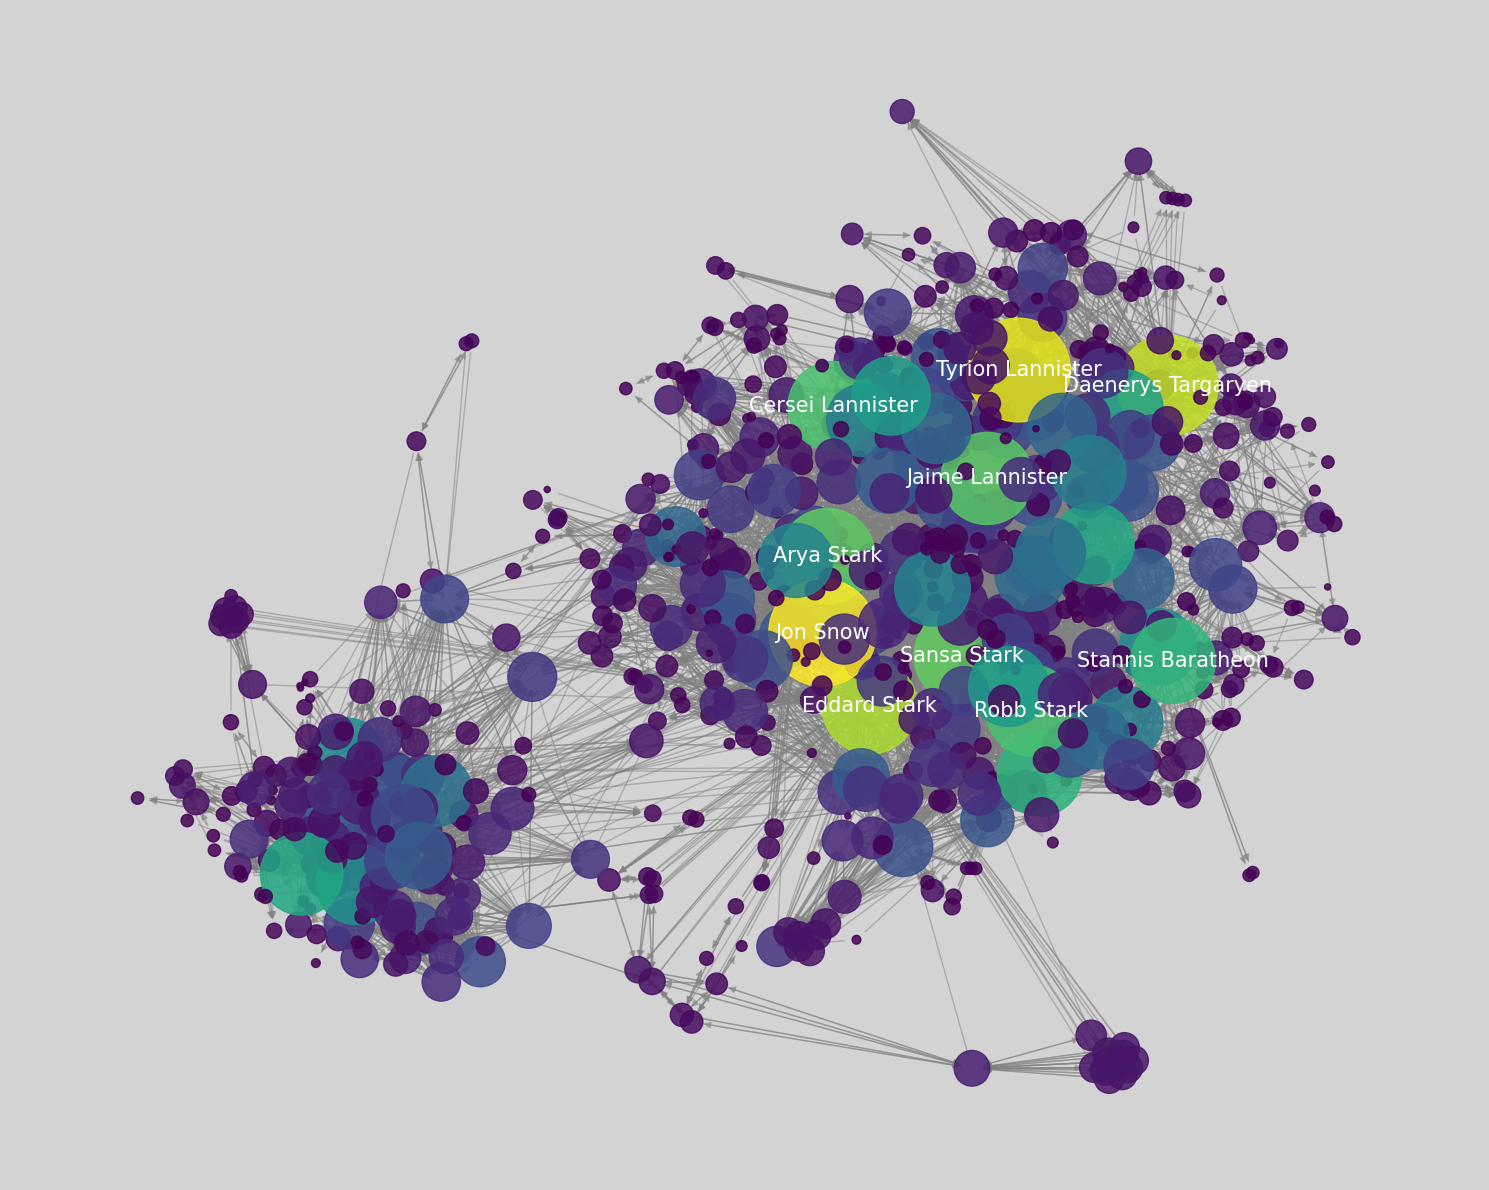

In [47]:
plot_character_network(dg_char, weighted=False)

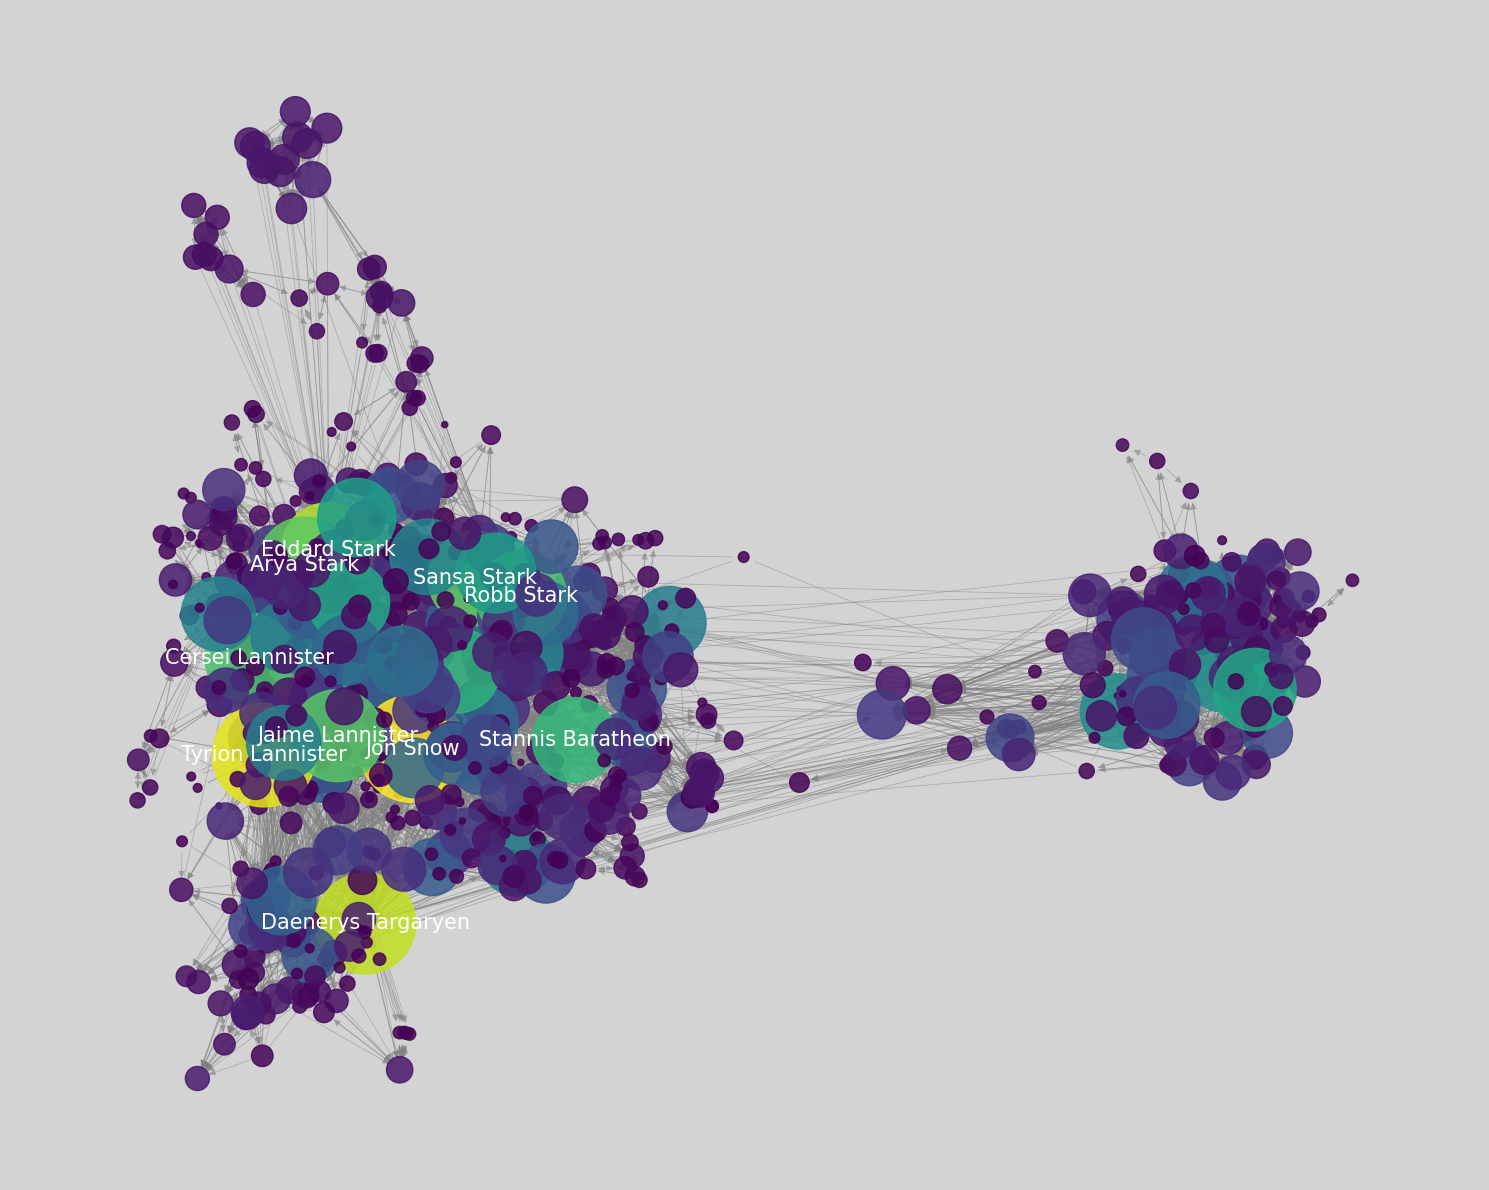

In [48]:
plot_character_network(dgw_char, weighted=True)

## Looking at communities

In [68]:
dg_undir = dg_char.to_undirected()
dgw_undir = dgw_char.to_undirected()

In [69]:
# k-clique percolation with k = 4
print("Finding overlapping communities with k=4...\n")

k = 4

# Unweighted graph
communities_dg = list(nx.community.k_clique_communities(dg_undir, k))
print(f"Unweighted k={k}: Found {len(communities_dg)} overlapping communities")

# Weighted graph (treated structurally as unweighted)
communities_dgw = list(nx.community.k_clique_communities(dgw_undir, k))
print(f"Weighted k={k}: Found {len(communities_dgw)} overlapping communities")


Finding overlapping communities with k=4...

Unweighted k=4: Found 16 overlapping communities
Weighted k=4: Found 16 overlapping communities


## TF-IDF

In [70]:
sorted(communities_dgw[1:],key=len,reverse=True)

[frozenset({'Andar Royce',
            'Diana Royce',
            'Donal Royce',
            'Eddard Stark',
            'Elena Egen',
            'Junia Royce',
            'Mavis Royce',
            'Maxim Royce',
            'Maynard Royce',
            'Paxter Royce',
            'Robar Royce (lord)',
            'Rusalia Egen',
            'Serena Royce',
            'Waymar Royce (son of Andar)',
            'Xander Egen',
            'Yohn Royce'}),
 frozenset({'Argalia Baratheon',
            'Brune Baratheon',
            'Bryte Baratheon',
            'Gude Baratheon',
            'Jon Baratheon',
            'Lex Baratheon',
            'Lorax Baratheon',
            'Mace Baratheon',
            'Martyn Baratheon',
            'Miriam Baratheon',
            'Orys Baratheon (son of William)',
            'Theodor Baratheon',
            'Tommax Baratheon',
            'William Baratheon (son of William)',
            'Wineiri Baratheon'}),
 frozenset({'Dareon Hunter',
     

In [ ]:
# TF/TF-IDF style analysis on k=4 clique communities from dgw_undir

print(f"=== TF Analysis on K-Clique Communities (k=4) ===\n")

kclique_communities = sorted(communities_dgw[1:],key=len,reverse=True)

got_files_path = 'GoT_files_final'

# Custom stop words
from sklearn.feature_extraction.text import TfidfVectorizer
base_stop_words = set(TfidfVectorizer(stop_words='english').get_stop_words())
file_extensions = {'jpg', 'jpeg', 'png', 'gif', 'pdf', 'txt', 'doc', 'docx', 'html', 'htm', 
                    'xml', 'css', 'js', 'py', 'cpp', 'java', 'mp3', 'mp4', 'avi', 'mov', 'wav'}
file_related = {'ref', 'file', 'image', 'thumb', 'link', 'url', 'href', 'src', 'wiki', 
                'wikipedia', 'page', 'edit', 'http', 'https', 'www', 'com', 'org', 'net',
                'px', 'width', 'height', 'size', 'upload', 'media', 'category', 'template'}
stop_words = base_stop_words | file_extensions | file_related

# Load and tokenize k-clique community documents
kclique_token_list = {}
kclique_char_lists = {}

for i, comm in enumerate(kclique_communities):
    comm_tokens = []
    valid_chars = []
    
    for char in comm:
        file_path = os.path.join(got_files_path, f"{char}.txt")
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
                    
                    # Truncate after "==In the books==" section
                    in_books_idx = text.find('==In the books==')
                    if in_books_idx != -1:
                        next_section_start = in_books_idx + len('==In the books==')
                        next_section_idx = text.find('\n==', next_section_start)
                        if next_section_idx != -1:
                            text = text[:next_section_idx]
                    
                    text = text.lower()
                    # Simple tokenization
                    tokens = [
                        w for w in text.split()
                        if w.isalpha() and w not in stop_words and len(w) > 2
                    ]
                    
                    # Weight by character's degree in community
                    subgraph = dgw_undir.subgraph(comm)
                    degree = subgraph.degree(char, weight='weight')
                    repeat_count = max(1, int(np.log1p(degree)))
                    comm_tokens.extend(tokens * repeat_count)
                    valid_chars.append(char)
            except Exception:
                # Ignore files that cannot be opened/parsed
                pass
    
    if comm_tokens:
        name = f"K-Clique Community {i+1}"
        kclique_token_list[name] = comm_tokens
        kclique_char_lists[name] = valid_chars

print(f"Created {len(kclique_token_list)} k-clique community documents")
if kclique_char_lists:
    print(f"Average characters per community: "
            f"{np.mean([len(c) for c in kclique_char_lists.values()]):.1f}")
else:
    print("Average characters per community: 0.0")

# 1) Raw term counts from token lists
kclique_tf_raw = {c: Counter(toks) for c, toks in kclique_token_list.items()}

# 2) Augmented term frequency
def to_augmented(counter):
    if not counter:
        return {}
    m = max(counter.values())
    return {w: 0.5 + 0.5 * (c / m) for w, c in counter.items()}

kclique_tf_aug = {c: to_augmented(cnt) for c, cnt in kclique_tf_raw.items()}


=== TF Analysis on K-Clique Communities (k=4) ===

Created 15 k-clique community documents
Average characters per community: 6.8


In [ ]:
# Calculate IDF and TF-IDF for k-clique communities

# Total number of community documents
N_kclique = len(kclique_tf_aug)

# Document frequency: number of communities containing each word
all_words_kclique = set(w for c in kclique_tf_aug for w in kclique_tf_aug[c])
df_kclique = {w: sum(1 for c in kclique_tf_aug if w in kclique_tf_aug[c]) for w in all_words_kclique}

# IDF with base-10 logarithm
idf_kclique = {w: math.log10(N_kclique / df_kclique[w]) for w in df_kclique}

# TF-IDF combination
tfidf_kclique = {
    c: {w: kclique_tf_aug[c][w] * idf_kclique[w] for w in kclique_tf_aug[c] if w in idf_kclique}
    for c in kclique_tf_aug
}

## Word clouds for communities


=== Creating Word Clouds for K-Clique Communities ===



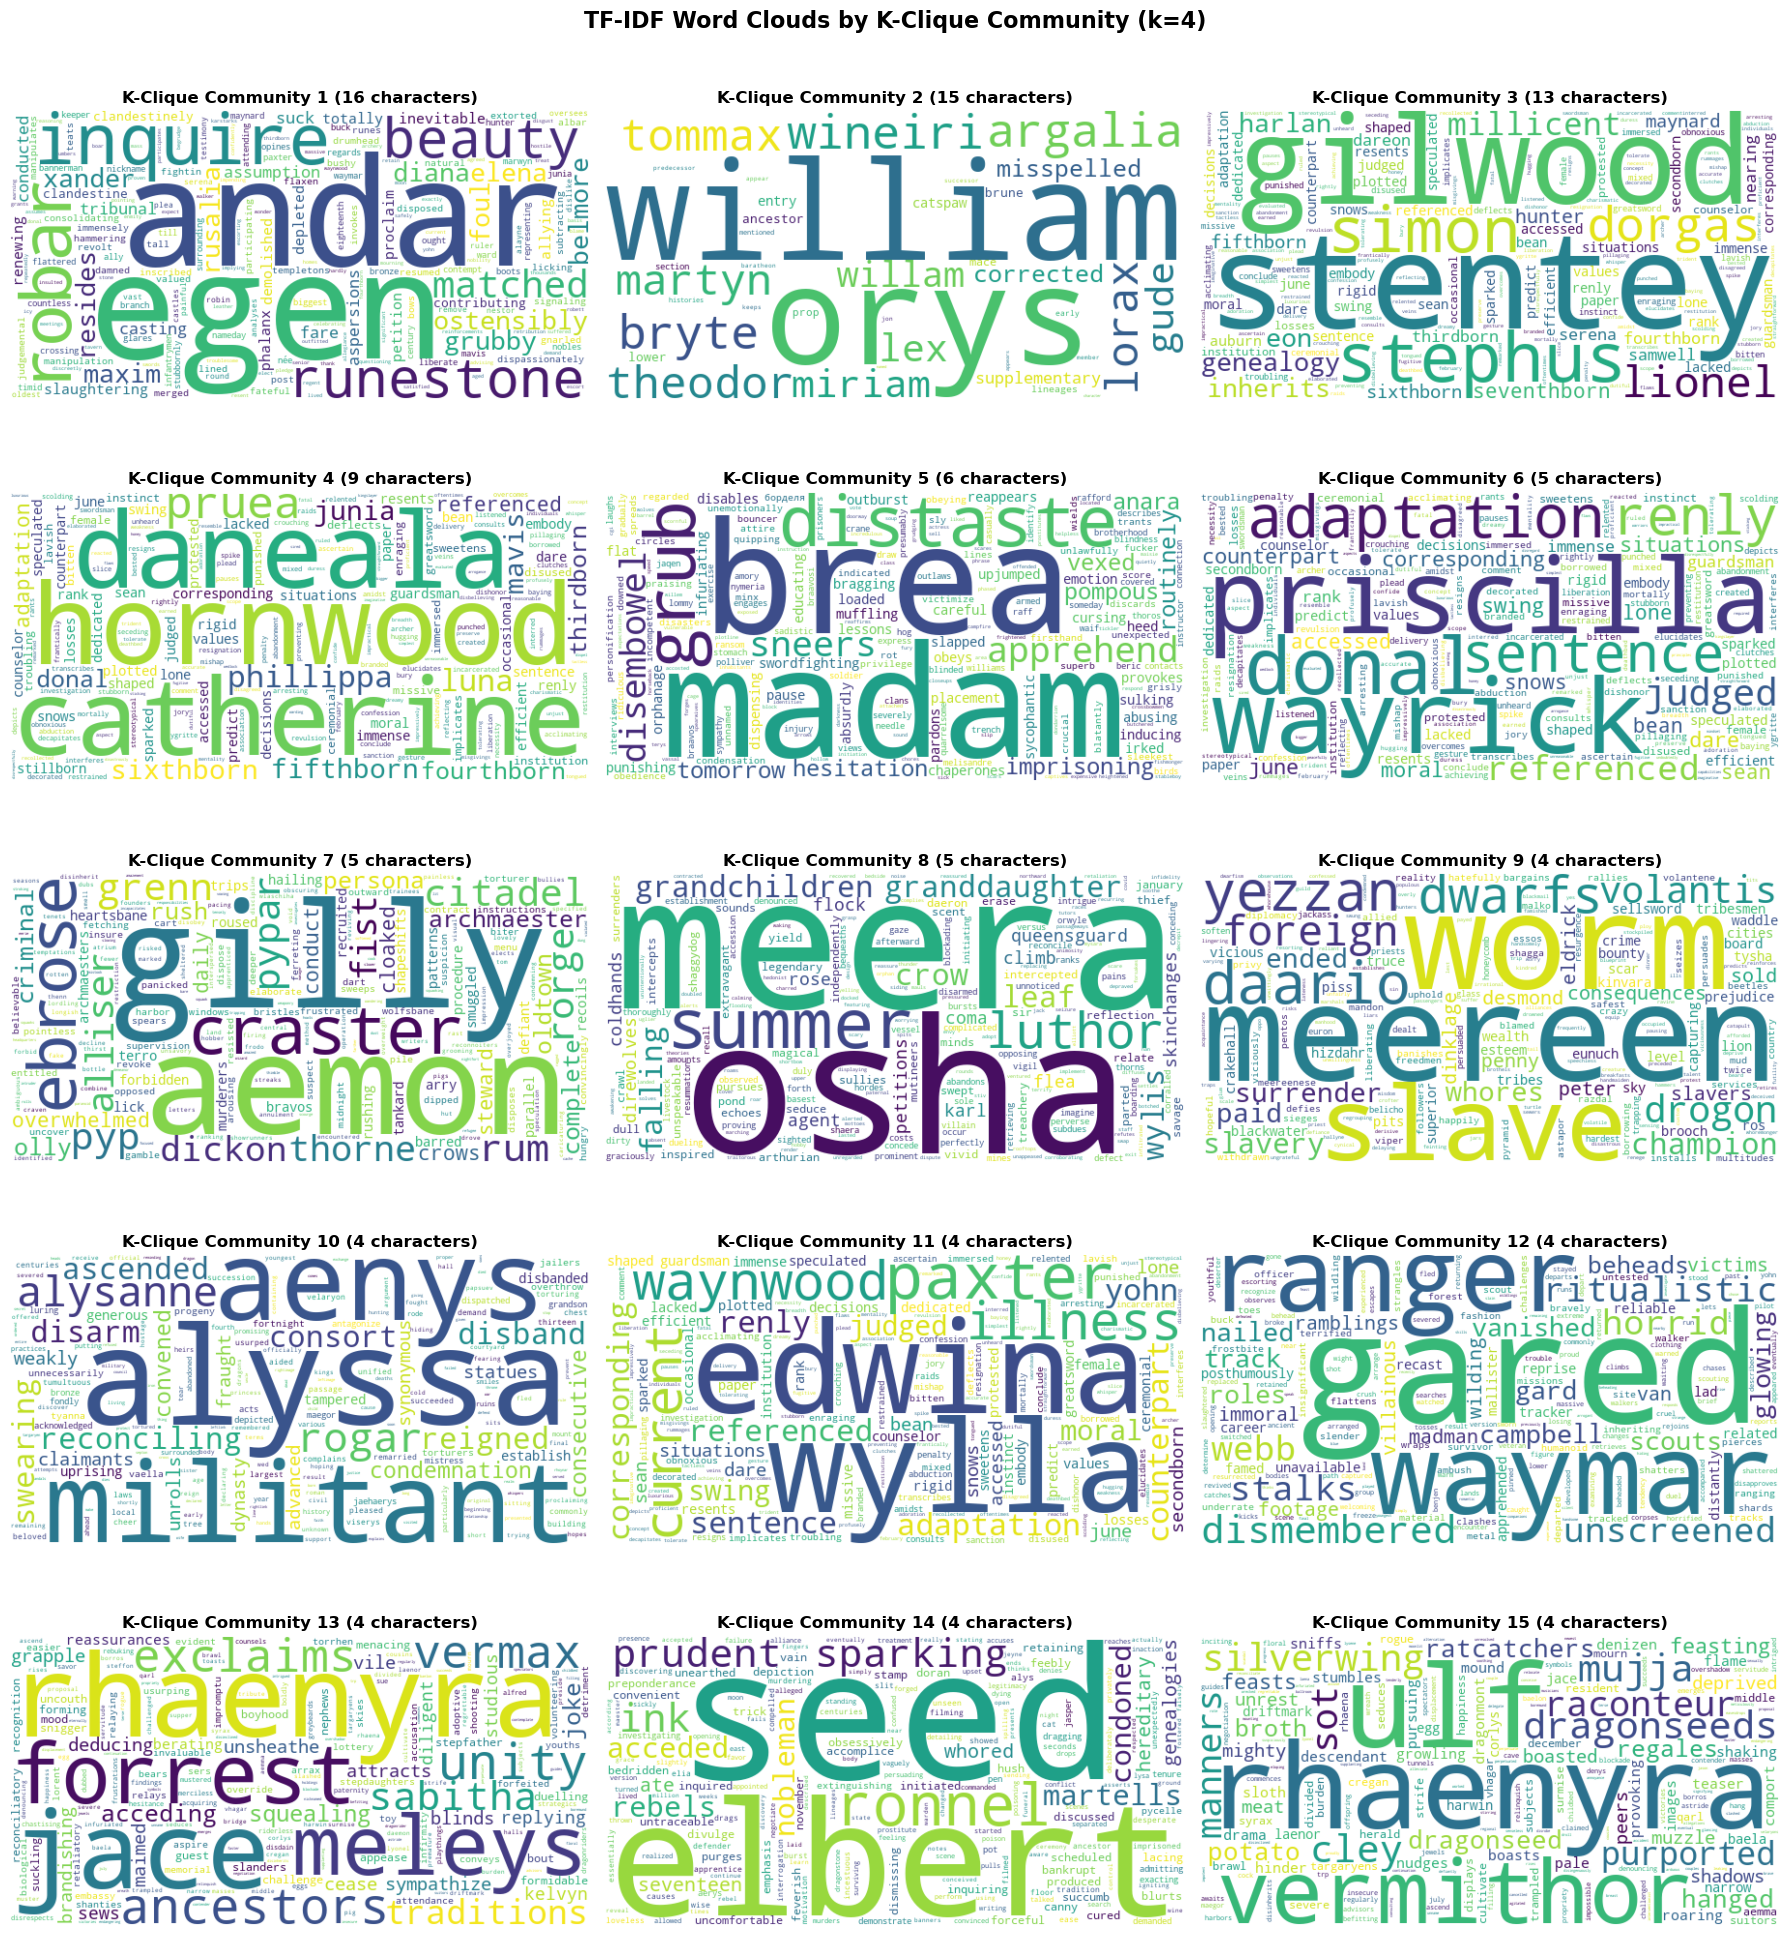

In [75]:
print("\n=== Creating Word Clouds for K-Clique Communities ===\n")

# Config
scale_tfidf = True   # normalize TF-IDF values to [0,1]
cols = 3
communities_list_kclique = list(tfidf_kclique.keys())
rows = math.ceil(len(communities_list_kclique) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for i, c in enumerate(communities_list_kclique):
    ax = axes[i]
    scores = tfidf_kclique[c]
    if not scores:
        ax.axis("off")
        continue

    data = scores
    if scale_tfidf:
        max_val = max(data.values())
        data = {w: v / max_val for w, v in data.items()}  # normalize to [0,1]

    wc = WordCloud(width=600, height=300, background_color="white",
                    collocations=False).generate_from_frequencies(data)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{c} ({len(kclique_char_lists[c])} characters)", fontsize=12, fontweight='bold')

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle(f'TF-IDF Word Clouds by K-Clique Community (k=4)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [83]:
# Convert frozensets to lists for JSON serialization
communities_to_save = [list(comm) for comm in sorted(communities_dgw,key=len,reverse=True)]

with open('kclique_k4_communities_final.json', 'w', encoding='utf-8') as f:
    json.dump(communities_to_save, f, indent=2)

print(f"Saved {len(communities_to_save)} k=4 clique communities to 'kclique_k4_communities.json'")

Saved 16 k=4 clique communities to 'kclique_k4_communities.json'
